# Лабораторная 4. Метод k-ближайших соседей (k-NN)

## Импорт необходимых библиотек

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Загружаем данные


In [27]:
df = pd.read_csv("WineDataset.csv")
df.head()

,Alcohol,Malic Acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Wine
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,1
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,1
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,1
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,1
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,1


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       178 non-null    float64
 1   Malic Acid                    178 non-null    float64
 2   Ash                           178 non-null    float64
 3   Alcalinity of ash             178 non-null    float64
 4   Magnesium                     178 non-null    float64
 5   Total phenols                 178 non-null    float64
 6   Flavanoids                    178 non-null    float64
 7   Nonflavanoid phenols          178 non-null    float64
 8   Proanthocyanins               178 non-null    float64
 9   Color intensity               178 non-null    float64
 10  Hue                           178 non-null    float64
 11  OD280/OD315 of diluted wines  178 non-null    float64
 12  Proline                       178 non-null    float64
 13  Wine 

## 1. Предварительная обработка данных


### Обработка пропущенных значений

In [29]:
df.isnull().sum()

,0
Alcohol,0
Malic Acid,0
Ash,0
Alcalinity of ash,0
Magnesium,0
Total phenols,0
Flavanoids,0
Nonflavanoid phenols,0
Proanthocyanins,0
Color intensity,0


In [30]:
# т.к. пропусков нет,
# вот универсальный способ заполнения
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

### Кодирование категориальных признаков

In [31]:
target_col = "Wine"
feature_cols = df.columns.drop(target_col)

X = df[feature_cols]
y = df[target_col].values

### Разделение на train/test

In [32]:
np.random.seed(43)

n = len(df)
indices = np.random.permutation(n)
train_size = int(0.8 * n)

train_idx = indices[:train_size]
test_idx = indices[train_size:]

train_df = df.iloc[train_idx].reset_index(drop=True)
test_df = df.iloc[test_idx].reset_index(drop=True)

print("Размер train:", train_df.shape)
print("Размер test:", test_df.shape)

Размер train: (142, 14)
Размер test: (36, 14)


In [33]:
X_train_raw = train_df[feature_cols]
y_train = train_df[target_col].values

X_test_raw = test_df[feature_cols]
y_test = test_df[target_col].values

### Масштабирование

Используем стандартизацию:
z = (x - mean) / std

Параметры mean и std считаем только по train и применяем к test

In [34]:
def standardize_fit(X_df: pd.DataFrame):
    X_num = X_df.astype(float)
    mean = X_num.mean()
    std = X_num.std(ddof=0).replace(0, 1)
    X_scaled = (X_num - mean) / std
    return X_scaled, mean, std

def standardize_transform(X_df: pd.DataFrame, mean: pd.Series, std: pd.Series):
    X_num = X_df.astype(float)
    return (X_num - mean) / std

In [35]:
X_train_scaled_df, mean_X, std_X = standardize_fit(X_train_raw)
X_test_scaled_df = standardize_transform(X_test_raw, mean_X, std_X)

X_train_scaled_df.head()

,Alcohol,Malic Acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,-0.416154,1.012359,0.034399,0.691975,0.462417,-0.930037,-0.791773,-1.560419,-1.347987,-0.048358,-0.759699,-1.855964,-0.459101
1,-1.195855,-0.488087,-0.111411,-0.240582,-1.236943,-1.087258,-0.498829,1.352910,0.102670,-1.184808,0.574535,-0.484344,-0.832305
2,1.004915,-0.714899,0.982159,0.225696,1.074187,1.035220,1.356480,0.354055,0.247735,0.650996,0.796908,-0.064461,1.189213
3,1.344462,-0.200211,-0.184315,-0.396009,0.394443,1.035220,1.278361,-1.144229,1.444528,0.279465,1.330601,0.775306,2.371023
4,-0.428729,-0.749793,-0.330125,0.443293,-1.304917,-1.433143,-0.537888,1.852338,0.066403,-0.900695,0.040841,-0.778263,-0.785654


## 2. Получаем и визуализируем статистику по датасету

### Статистика по датасету

In [36]:
df.describe(include="all")

,Alcohol,Malic Acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Wine
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,1.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,1.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,1.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,2.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,3.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,3.000000


### Гистограммы признаков

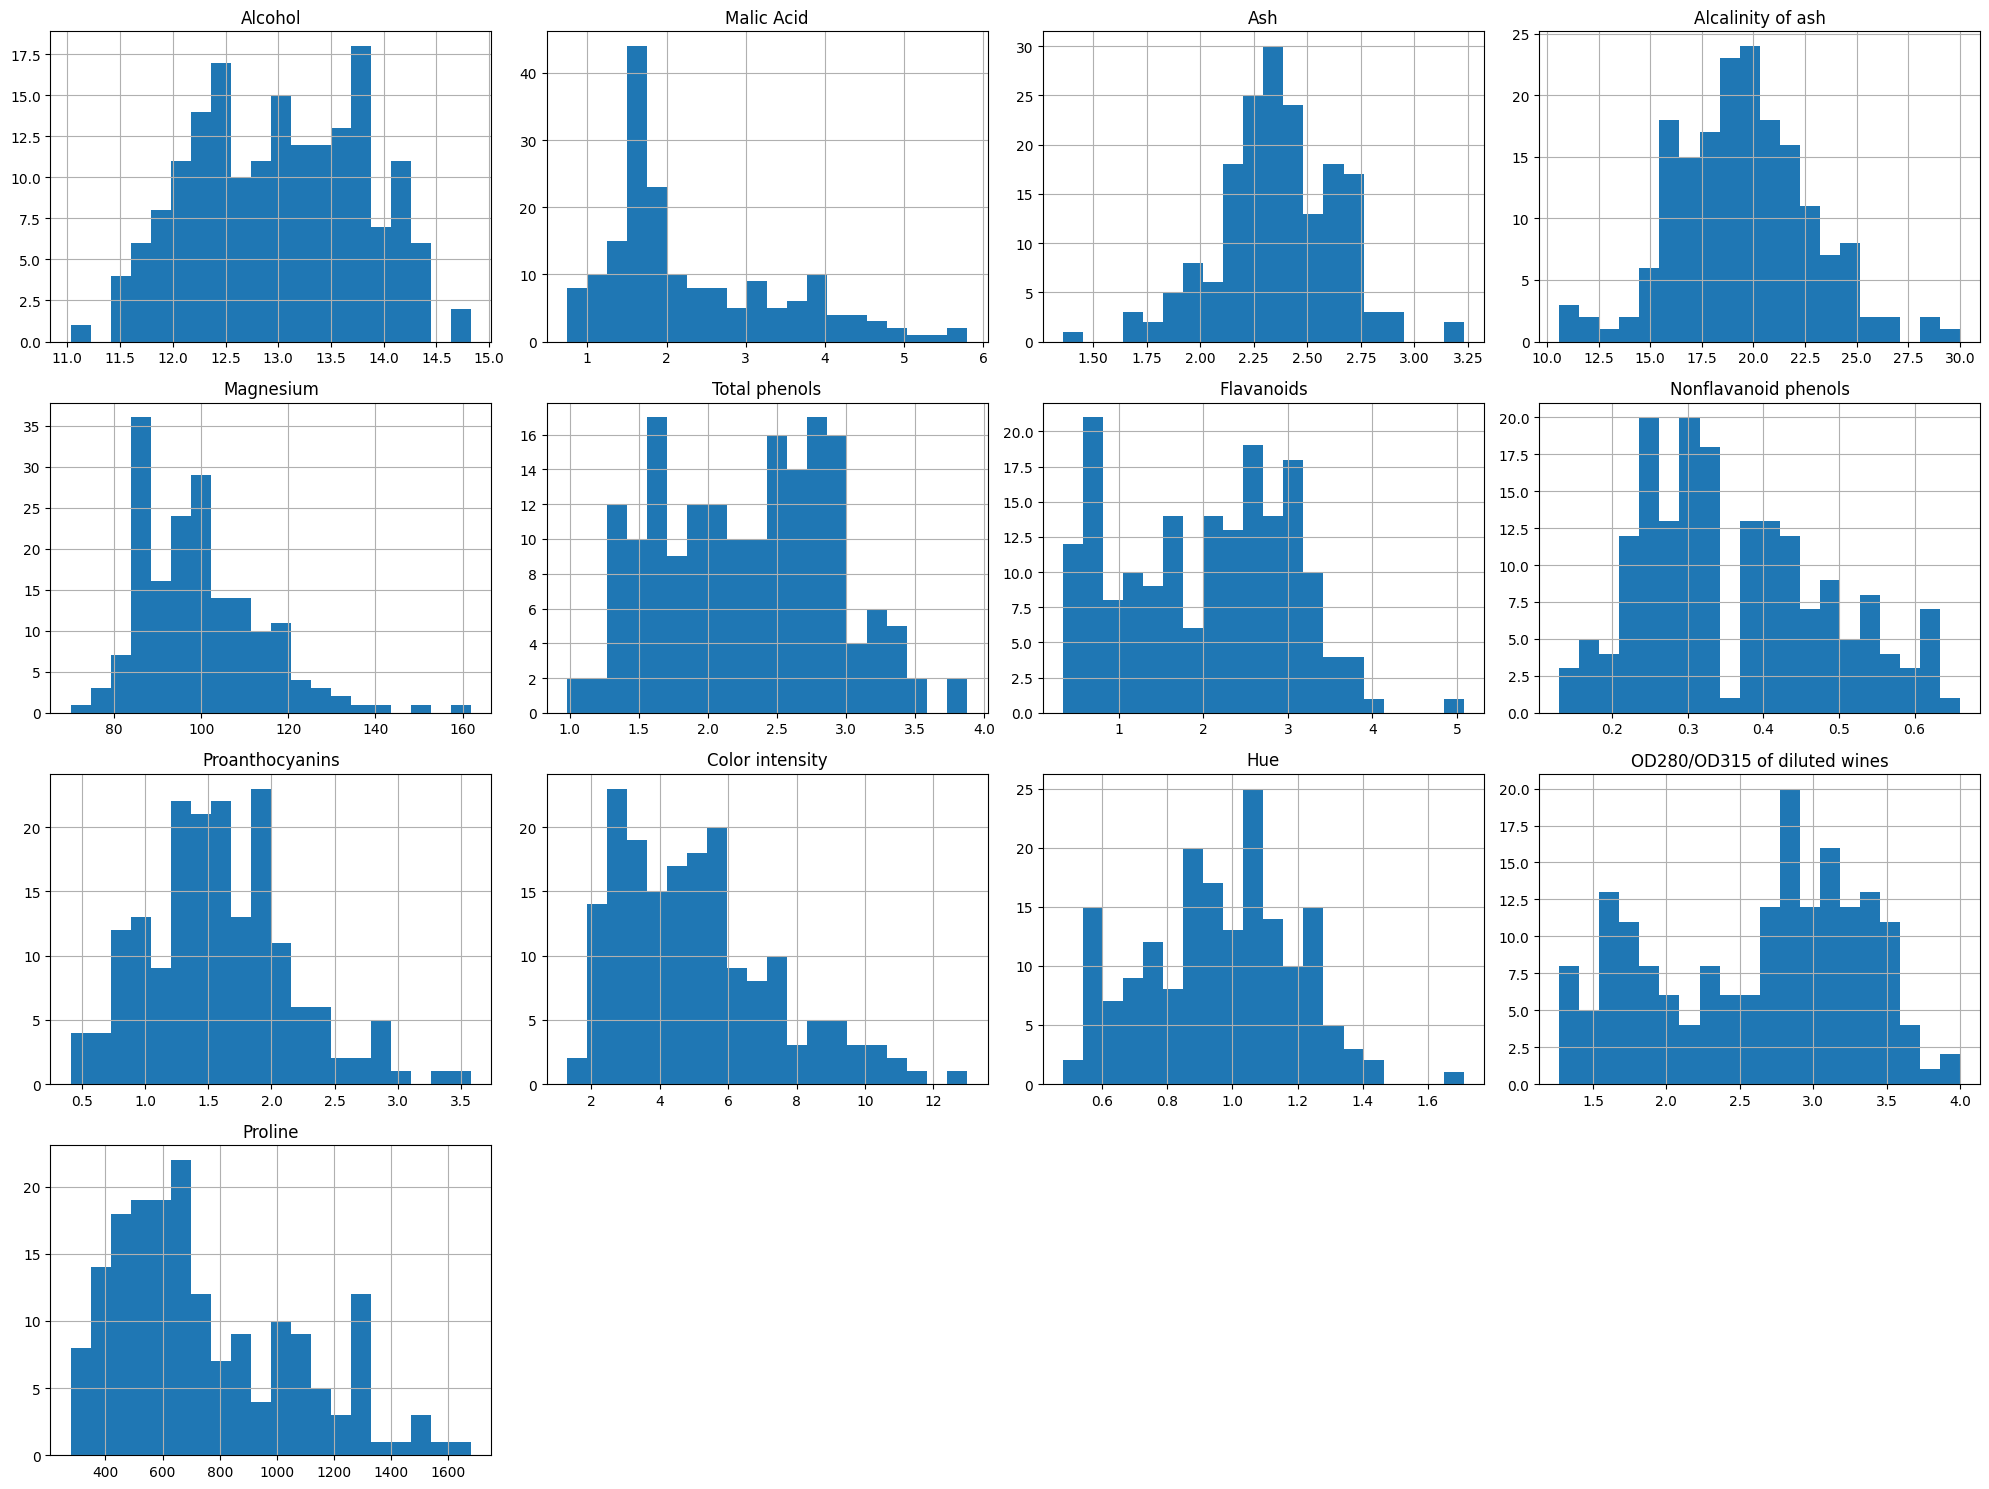

In [37]:
df[feature_cols].hist(bins=20, figsize=(20, 15))
plt.tight_layout()
plt.show()

### Корреляционная матрица

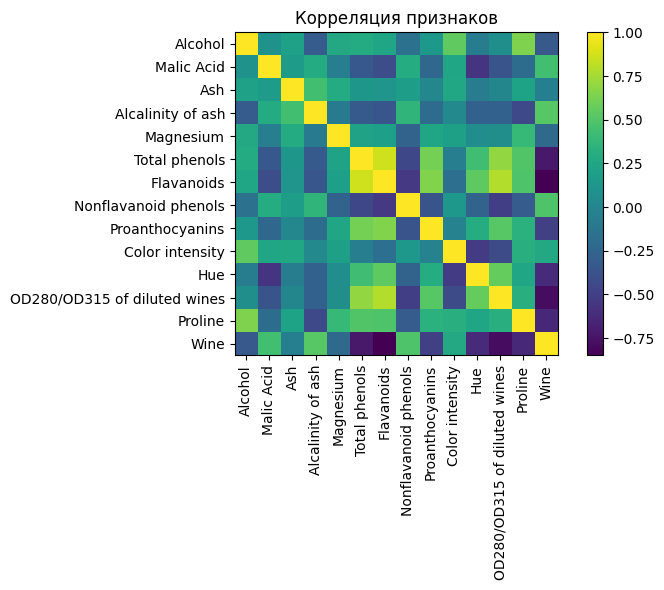

In [38]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Корреляция признаков")
plt.tight_layout()
plt.show()

### 3D визуализация

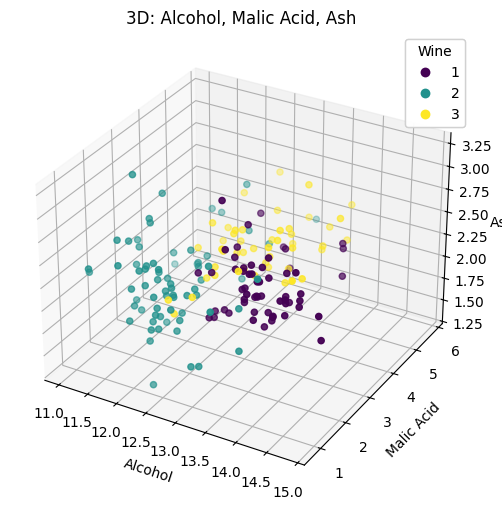

In [39]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

x_feat = "Alcohol"
y_feat = "Malic Acid"
z_feat = "Ash"

scatter = ax.scatter(
    df[x_feat], df[y_feat], df[z_feat],
    c=df[target_col],
    cmap="viridis"
)

ax.set_xlabel(x_feat)
ax.set_ylabel(y_feat)
ax.set_zlabel(z_feat)
ax.set_title("3D: Alcohol, Malic Acid, Ash")

legend1 = ax.legend(*scatter.legend_elements(), title="Wine")
ax.add_artist(legend1)

plt.show()

## 3. Реализация kNN

In [40]:
def knn_predict(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, k: int):
    # считаем расстояния от тестового объекта до всех train
    # берём k ближайших
    # выбираем класс по большинству голосов
    y_pred = []
    for x in X_test:
        distances = np.sqrt(np.sum((X_train - x) ** 2, axis=1))  # евклидово
        nn_idx = np.argsort(distances)[:k]  # индексы k ближайших
        nn_labels = y_train[nn_idx]

        values, counts = np.unique(nn_labels, return_counts=True)
        majority_class = values[np.argmax(counts)]
        y_pred.append(majority_class)

    return np.array(y_pred)

### Матрица ошибок

In [45]:
def confusion_matrix_manual(y_true: np.ndarray, y_pred: np.ndarray):
    classes = np.unique(np.concatenate([y_true, y_pred]))
    n_classes = len(classes)
    cm = np.zeros((n_classes, n_classes), dtype=int)
    class_to_index = {cls: i for i, cls in enumerate(classes)}

    for yt, yp in zip(y_true, y_pred):
        i = class_to_index[yt]
        j = class_to_index[yp]
        cm[i, j] += 1

    return cm, classes

def accuracy_score_manual(y_true: np.ndarray, y_pred: np.ndarray):
    return np.mean(y_true == y_pred)

In [46]:
def plot_confusion_matrix(cm: np.ndarray, classes):
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, cmap="Blues", interpolation="nearest")
    plt.title("Матрица ошибок")
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes)
    plt.yticks(ticks, classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

## 4. Модели kNN

In [47]:
all_feature_names = list(X_train_scaled_df.columns)
all_feature_names

['Alcohol',
 'Malic Acid',
 'Ash',
 'Alcalinity of ash',
 'Magnesium',
 'Total phenols',
 'Flavanoids',
 'Nonflavanoid phenols',
 'Proanthocyanins',
 'Color intensity',
 'Hue',
 'OD280/OD315 of diluted wines',
 'Proline']

### Оценка модели при разных k


In [48]:
def evaluate_knn_model(X_train_df, X_test_df, y_train, y_test, feature_names, k_values):
    print("Признаки:", feature_names)

    X_train = X_train_df[feature_names].values
    X_test  = X_test_df[feature_names].values

    for k in k_values:
        print("\n=== k =", k, "===")
        y_pred = knn_predict(X_train, y_train, X_test, k)

        acc = accuracy_score_manual(y_test, y_pred)
        cm, classes = confusion_matrix_manual(y_test, y_pred)

        print(f"Accuracy: {acc:.3f}")
        print("Матрица ошибок:")
        print(cm)

        plot_confusion_matrix(cm, classes)

### Модель 1


In [49]:
np.random.seed(0)

features_model1 = list(np.random.choice(all_feature_names, size=5, replace=False))
features_model1

[np.str_('Flavanoids'),
 np.str_('OD280/OD315 of diluted wines'),
 np.str_('Magnesium'),
 np.str_('Hue'),
 np.str_('Ash')]

Признаки: [np.str_('Flavanoids'), np.str_('OD280/OD315 of diluted wines'), np.str_('Magnesium'), np.str_('Hue'), np.str_('Ash')]

=== k = 3 ===
Accuracy: 0.833
Матрица ошибок:
[[11  1  0]
 [ 4 12  1]
 [ 0  0  7]]


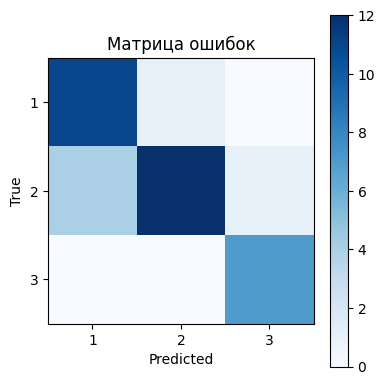


=== k = 5 ===
Accuracy: 0.806
Матрица ошибок:
[[12  0  0]
 [ 5 10  2]
 [ 0  0  7]]


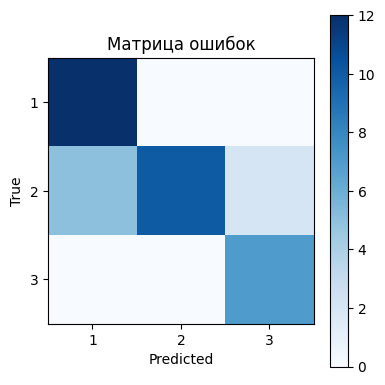


=== k = 10 ===
Accuracy: 0.806
Матрица ошибок:
[[12  0  0]
 [ 6 10  1]
 [ 0  0  7]]


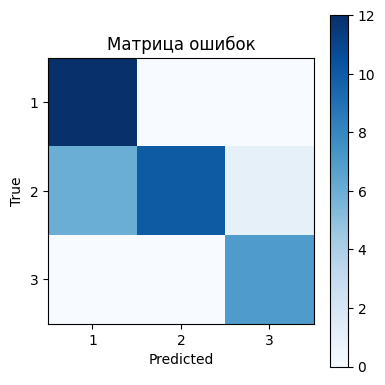

In [50]:
k_values = [3, 5, 10]

evaluate_knn_model(
    X_train_scaled_df, X_test_scaled_df,
    y_train, y_test,
    features_model1,
    k_values
)

### Модель 2

In [51]:
features_model2 = ["Alcohol", "Malic Acid", "Ash"]
features_model2

['Alcohol', 'Malic Acid', 'Ash']

Признаки: ['Alcohol', 'Malic Acid', 'Ash']

=== k = 3 ===
Accuracy: 0.833
Матрица ошибок:
[[11  0  1]
 [ 2 14  1]
 [ 1  1  5]]


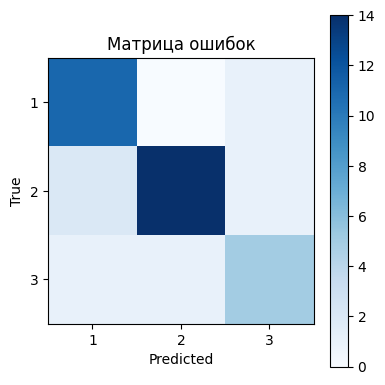


=== k = 5 ===
Accuracy: 0.806
Матрица ошибок:
[[11  0  1]
 [ 2 14  1]
 [ 2  1  4]]


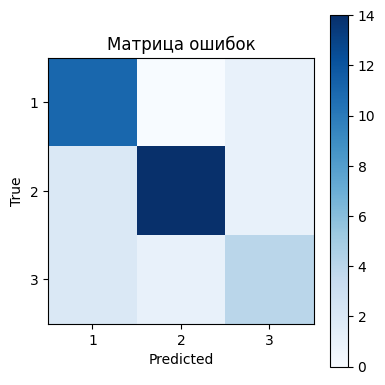


=== k = 10 ===
Accuracy: 0.806
Матрица ошибок:
[[11  0  1]
 [ 2 14  1]
 [ 1  2  4]]


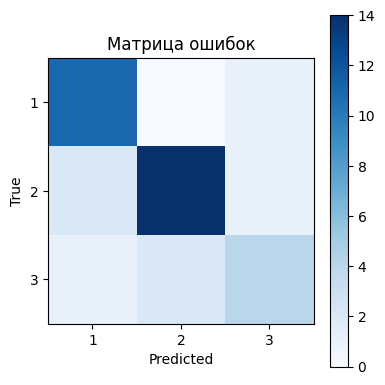

In [52]:
evaluate_knn_model(
    X_train_scaled_df, X_test_scaled_df,
    y_train, y_test,
    features_model2,
    k_values
)